# Natural Language to SQL for Snowflake

This notebook demonstrates how to convert natural language questions to SQL queries for Snowflake databases using LangChain, GROQ (LLaMA models), and other tools.

In [8]:
%pip install -U -q langchain-community langchain-core langgraph langchain-groq snowflake-connector-python dotenv pandas sqlglot

In [9]:
import os
import json
import pandas as pd
import snowflake.connector
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate

# Load from .env
# load_dotenv()
from google.colab import userdata

os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')

In [10]:
def load_credentials(file_path):
    """
    Load Snowflake credentials from a JSON file.

    Args:
        file_path (str): Path to the JSON file containing credentials

    Returns:
        dict: Dictionary with Snowflake credentials
    """
    with open(file_path, 'r') as file:
        return json.load(file)

# Path to credentials file
# credentials_path = "yourcredentialsfilepath/snowflake_credential.json"

# Load credentials
# credentials = load_credentials(credentials_path)

credentials = {"user": "shivamsuchak997",
    "password": "Rickofiz@99796",
    "account": "RSRSBDK-YDB67606"}

# Connect to Snowflake
conn = snowflake.connector.connect(
    user=credentials['user'],
    password=credentials['password'],
    account=credentials['account']
)

print(f"Successfully connected to Snowflake!")

Successfully connected to Snowflake!


In [11]:
# Create a cursor object
cursor = conn.cursor()

# List databases
cursor.execute("SHOW DATABASES")

# Fetch all results
results = cursor.fetchall()

# Get column names
columns = [desc[0] for desc in cursor.description]

# Convert to DataFrame
database_df = pd.DataFrame(results, columns=columns)

# Print available databases
print("Available databases:")
print(database_df[['name', 'created_on']])

Available databases:
                                        name                       created_on
0                             ADVENTUREWORKS 2024-10-23 19:34:13.495000-07:00
1                                   AIRLINES 2024-10-23 19:33:14.040000-07:00
2    AMAZON_VENDOR_ANALYTICS__SAMPLE_DATASET 2024-09-20 06:48:25.172000-07:00
3                                     AUSTIN 2024-10-23 19:18:41.171000-07:00
4                         BANK_SALES_TRADING 2024-10-23 19:34:02.763000-07:00
..                                       ...                              ...
151                          WORD_VECTORS_US 2024-10-23 19:17:48.666000-07:00
152                               WORLD_BANK 2024-10-23 16:53:15.845000-07:00
153                                      WWE 2024-10-23 19:33:26.483000-07:00
154                  YES_ENERGY__SAMPLE_DATA 2024-09-20 06:54:48.610000-07:00
155                            _1000_GENOMES 2024-10-25 23:51:28.305000-07:00

[156 rows x 2 columns]


In [12]:
# Select a database to use for this example
# You can modify this to use any database from the list
selected_database = "ADVENTUREWORKS"  # Replace with your desired database from the available list

# Use the selected database
cursor.execute(f"USE DATABASE {selected_database}")
print(f"Using database: {selected_database}")

# List all schemas in the selected database
cursor.execute("SHOW SCHEMAS")
schemas_results = cursor.fetchall()
schemas_columns = [desc[0] for desc in cursor.description]
schemas_df = pd.DataFrame(schemas_results, columns=schemas_columns)
print("\nAvailable schemas:")
print(schemas_df[['name', 'created_on']])

Using database: ADVENTUREWORKS

Available schemas:
                 name                       created_on
0      ADVENTUREWORKS 2024-10-23 19:34:14.488000-07:00
1  INFORMATION_SCHEMA 2025-05-24 08:29:22.337000-07:00
2              PUBLIC 2024-10-23 19:34:13.571000-07:00


In [13]:
# Select a schema to use
selected_schema = schemas_df['name'].iloc[0]  # Use the first schema by default
cursor.execute(f"USE SCHEMA {selected_schema}")
print(f"Using schema: {selected_schema}")

# List all tables in the selected schema
cursor.execute("SHOW TABLES")
tables_results = cursor.fetchall()
tables_columns = [desc[0] for desc in cursor.description]
tables_df = pd.DataFrame(tables_results, columns=tables_columns)
print("\nAvailable tables:")
print(tables_df[['name', 'created_on']])

Using schema: ADVENTUREWORKS

Available tables:
                                     name                       created_on
0                   COUNTRYREGIONCURRENCY 2024-10-24 17:25:02.979000-07:00
1                            CURRENCYRATE 2024-10-24 17:25:54.856000-07:00
2                                 PRODUCT 2024-10-24 17:25:30.935000-07:00
3                         PRODUCTCATEGORY 2024-10-24 17:26:20.778000-07:00
4                      PRODUCTDESCRIPTION 2024-10-24 17:24:53.619000-07:00
5   PRODUCTMODELPRODUCTDESCRIPTIONCULTURE 2024-10-24 17:26:09.224000-07:00
6                           PRODUCTREVIEW 2024-10-24 17:24:30.998000-07:00
7                      PRODUCTSUBCATEGORY 2024-10-24 17:24:24.059000-07:00
8                        SALESORDERDETAIL 2024-10-24 17:26:00.973000-07:00
9                        SALESORDERHEADER 2024-10-24 17:25:20.768000-07:00
10                            SALESPERSON 2024-10-24 17:24:45.308000-07:00
11                SALESPERSONQUOTAHISTORY 2024-10-24

In [14]:
# Function to get schema information for a table
def get_table_schema(table_name):
    cursor.execute(f"DESCRIBE TABLE {table_name}")
    desc_results = cursor.fetchall()
    desc_columns = [desc[0] for desc in cursor.description]
    result_df = pd.DataFrame(desc_results, columns=desc_columns)

    # Ensure we preserve the exact case from Snowflake for column names
    # This is critical because Snowflake is case-sensitive when querying
    if 'name' in result_df.columns:
        # Make sure we're getting the exact case representation from Snowflake
        cursor.execute(f"SELECT column_name FROM information_schema.columns WHERE table_name = '{table_name.upper()}'")
        column_names_results = cursor.fetchall()

        # If we got results from information_schema, use those exact names
        if column_names_results:
            # Create a mapping of uppercase names to actual case names
            case_mapping = {name[0].upper(): name[0] for name in column_names_results}

            # Apply the case mapping to the result dataframe
            result_df['original_name'] = result_df['name'].apply(
                lambda x: case_mapping.get(x.upper(), x) if isinstance(x, str) else x
            )
            # Use the original case for display but keep the name column for other operations
            result_df['display_name'] = result_df['original_name']

    return result_df

# Collect schema information for all tables
schema_info = "# SNOWFLAKE CASE SENSITIVITY NOTICE:\n"
schema_info += "# In Snowflake, identifiers (table names, column names) are case-insensitive by default\n"
schema_info += "# but are stored in UPPERCASE unless quoted. When writing SQL, use the exact case shown below\n"
schema_info += "# or enclose identifiers in double quotes if using lowercase (e.g., \"columnname\").\n\n"

for table in tables_df['name'].values:
    actual_table_name = table  # Keep original case from Snowflake
    schema_info += f"Table: {actual_table_name}\n"
    table_schema = get_table_schema(table)

    # Preserve the exact column names and types
    column_info = []
    for idx, row in table_schema.iterrows():
        # Use display_name if available, otherwise fall back to name
        if 'display_name' in table_schema.columns:
            col_name = row['display_name']
        else:
            col_name = row['name']
        col_type = row['type']
        column_info.append(f"{col_name:<30} {col_type}")

    schema_info += "\n".join(column_info) + "\n\n"

print("Schema information collected for all tables.")

Schema information collected for all tables.


In [39]:
# Setup the language model
llm = ChatGroq(model='llama3-70b-8192') # llama3-70b-8192, llama-3.3-70b-versatile # Use appropriate model name
print(llm.invoke('who are you?').content)

I'm an artificial intelligence model known as Llama. Llama stands for "Large Language Model Meta AI."


In [40]:
# Initial state definition
class AgentState(TypedDict):
    question: str
    sql_query: str
    query_result: str
    query_rows: list
    attempts: int
    relevance: str
    final_answer: str
    sql_error: bool

In [41]:
# Agent 1: Determines if the user NL-input is relevant to the db schema
class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'."
    )

def check_relevance(state: AgentState):
    question = state["question"]
    print(f"Checking relevance of the question: {question}")
    system = """You are a highly skilled SQL expert. Your task is to evaluate whether a given natural language question is relevant to a database based on its schema.

    Use the schema below to determine whether the question can reasonably be answered using the available tables and columns.

    ---
    Schema:
    {schema}
    ---

    Instructions:
    1. Carefully read the user's question.
    2. Check whether the schema contains the necessary tables and columns to answer the question.
    3. If the question can be answered using the schema, respond with **"relevant"**.
    4. If the schema lacks the necessary information, respond with **"not_relevant"**.
    5. Your response must be either **"relevant"** or **"not_relevant"** only—do not explain or elaborate.

    Output Format:
    relevant
    or
    not_relevant
    """
    human = f"Question: {question}"
    check_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human),
        ]
    )

    structured_llm = llm.with_structured_output(CheckRelevance)
    relevance_checker = check_prompt | structured_llm
    try:
      relevance = relevance_checker.invoke({'schema': schema_info})
      state["relevance"] = relevance.relevance.lower().strip()
      print(f"Relevance determined: {state['relevance']}")
    except Exception as e:
      print(f"Error during relevance check: {e}")
      state["relevance"] = "not_relevant"
      state["sql_error"] = True
    return state

In [88]:
# Agent 2: Converts natural language to SQL queries
class ConvertToSQL(BaseModel):
    sql_query: str = Field(
        description="The SQL query corresponding to the user's natural language question."
    )

def convert_nl_to_sql(state: AgentState):
    question = state["question"]
    print(f"Converting question to SQL for user: {question}")
    system = """
    You are a highly skilled SQL generation assistant for Snowflake. Your task is to convert a user's natural language question into a valid, syntactically correct, and semantically meaningful SQL query using Snowflake SQL dialect.

    Follow these strict rules:

    1. **Use only the tables and columns provided in the schema below**. Do not invent or reference tables/columns that are not explicitly listed.
    2. **Be extremely careful with case sensitivity**. Snowflake identifiers are case-insensitive by default but stored in UPPERCASE unless quoted.
      - Use the EXACT CASE as shown in the schema for table and column names
      - Always enclose column names in DUBLE QUOTES (e.g., "column_name") but NOT table names with exact case, for example:
          > SELECT "column_name" FROM TABLE_NAME;
          > SELECT x."column_1" AS x_name, y."column_2" AS y_name FROM TABLENAME1 x JOIN TABLENAME2 y ON x."id" = y."id";

      - The database is highly case sensitive. Make sure to use the **EXACT** case as shown in the schema.
      - DO NOT use mixed case or assume case insensitivity
      - For columns with complex names like "CULTUREID" or compound words, maintain the EXACT case shown in the schema
      - When in doubt, add double quotes around column names (e.g., "CULTUREID") to ensure precise matching
    3. **Understand the relationships between tables** and use JOINs accordingly where appropriate.
    4. **Avoid using `SELECT *`**. Instead, return only the specific columns that are relevant to answering the user's question.
    5. Use appropriate **filters, sorting, and grouping** based on the user's intent (e.g., time ranges, categories, totals).
    6. If necessary, use **aggregations** (COUNT, AVG, MAX, etc.) when the question asks for summaries or statistics.
    7. Maintain clarity and simplicity. Prioritize correctness over cleverness.

    Before generating the SQL:
    - Carefully analyze the user's question.
    - Check the exact spelling and case of all tables and columns in the schema.
    - Infer any implicit intent (e.g., filtering, ordering) only if it logically follows from the question.
    - Never assume facts that are not supported by the schema or the question.

    Schema:
    {table_info}

    Now, generate the SQL query that answers the following user question:
    """

    convert_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Question: {question}"),
        ]
    )

    structured_llm = llm.with_structured_output(ConvertToSQL)
    sql_generator = convert_prompt | structured_llm
    try:
      result = sql_generator.invoke({"question": question, "table_info": schema_info})
      state["sql_query"] = result.sql_query.strip()
    except Exception as e:
      print(f"Failed to generate SQL: {e}")
      state["sql_query"] = ""
      state["sql_error"] = True
    print(f"Generated SQL query: {state['sql_query']}")
    return state

In [65]:
# Agent 3: Executes generated SQL query
def execute_query(state: AgentState):
    """Execute SQL query and update state based on outcome."""
    sql_query = state["sql_query"]
    print(f"Executing SQL query: {sql_query}")

    try:
        # Execute the query
        cursor.execute(sql_query)
        results = cursor.fetchall()

        # Get column names
        columns = [desc[0] for desc in cursor.description]

        # Convert to DataFrame
        df = pd.DataFrame(results, columns=columns)

        if df.empty:
            state["query_result"] = "No data found for the specified query."
        else:
            state["query_result"] = df.to_string()

        state["sql_error"] = False
    except Exception as e:
        print(f"Error during SQL execution: {e}")
        state["sql_error"] = True
        state["query_result"] = str(e)

        # Check for case sensitivity errors in the error message
        error_msg = str(e).lower()
        if ("invalid identifier" in error_msg or "object does not exist" in error_msg):
            # Add specific info about case sensitivity issues to help with regeneration
            state["query_result"] += "\n\nThis appears to be a case sensitivity issue. Remember that in Snowflake:\n"
            state["query_result"] += "1. Identifiers are case-insensitive but stored in UPPERCASE unless quoted\n"
            state["query_result"] += "2. Use the EXACT CASE as shown in the schema\n"
            state["query_result"] += "3. When using identifiers exactly as shown in the schema, quote them with double quotes\n"
            state["query_result"] += "4. For complex table or column names like PRODUCTMODELPRODUCTDESCRIPTIONCULTURE or CULTUREID, use double quotes\n"
            state["query_result"] += "5. Example: SELECT \"CULTUREID\" FROM \"PRODUCTMODELPRODUCTDESCRIPTIONCULTURE\" WHERE \"CULTUREID\" = 'en'"

    return state

In [66]:
# Agent 4: Based on SQL result, generates NL answer
def generate_answer(state: AgentState):
    """Answer question using retrieved information as context."""
    template = PromptTemplate.from_template(
    """You are an intelligent data assistant. Your task is to help answer the user's natural language question by using the provided SQL query and its result.

    You will be given:
    1. The original user question.
    2. The SQL query that was generated to answer the question.
    3. The result returned by executing that SQL query.

    Use this information to provide a helpful, clear, and concise answer to the user's question. If the result is empty or insufficient to answer the question confidently, respond accordingly.

    ---
    Question: {question}
    SQL Query: {sql_query}
    SQL Result: {query_result}
    ---

    Final Answer:""")

    llm_chain = template | llm | StrOutputParser()
    answer = llm_chain.invoke({
        "question": state["question"],
        "sql_query": state["sql_query"],
        "query_result": state["query_result"]
    })
    state["final_answer"] = answer
    return state

In [67]:
# Agent 5: Generates funny response if the user's query is not relevant to the db
def generate_funny_response(state: AgentState):
    print("Generating a funny response for an unrelated question.")
    system = """
    You are a witty, charming, and funny assistant whose job is to entertain users when they ask questions unrelated to the database or when no relevant answer can be provided.

    Your responses should:
    - Be playful and light-hearted.
    - Stay appropriate and friendly.
    - Acknowledge that the question isn't answerable via the database.
    - Gently steer the user back on track with a smile (figuratively).

    You are not required to be helpful — just be delightfully unhelpful in a clever way.
    """

    human_message = f"""
    The user asked a question that is unrelated to the database:
    '{state['question']}'
    Craft a humorous and creative response."""

    funny_prompt = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", human_message),
    ])

    funny_response = funny_prompt | llm | StrOutputParser()
    message = funny_response.invoke({})
    state["final_answer"] = message
    print("Generated funny response.")
    return state

In [68]:
# Agent 6: Rewrites the question if there isn't enough info
class RewrittenQuestion(BaseModel):
    question: str = Field(description="The rewritten question.")

def regenerate_query(state: AgentState):
    question = state["question"]
    print("Regenerating the SQL query by rewriting the question.")
    system = """
    You are an expert in SQL and natural language understanding for Snowflake databases.

    Your task is to **rewrite a user's natural language question** so that:
    - It is clear, complete, and unambiguous.
    - It is optimized to be converted into a precise and valid SQL query for Snowflake.
    - All necessary details (e.g. filters, relationships between tables, required joins, and any implied logic) are included.
    - The reformulated version preserves the intent and meaning of the original question but improves its structure for programmatic interpretation.

    CRITICAL: Snowflake has specific case sensitivity rules:
    - Table and column names are case-insensitive by default but stored in UPPERCASE unless quoted
    - Always use the EXACT CASE as shown in the schema
    - Example: If schema shows "PRODUCTMODELPRODUCTDESCRIPTIONCULTURE" table with "CULTUREID" column, use exactly that case
    - For combined or compound words like "CULTUREID" or "PRODUCTMODELPRODUCTDESCRIPTION", maintain the EXACT case shown
    - Never mix up the case of identifiers (avoid "Customerid", "CustomerID", etc.)
    - When in doubt, suggest using double quotes around identifiers (e.g., "CULTUREID")

    Avoid making assumptions not supported by the original question or schema.
    """

    rewrite_prompt = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", "Original Question: {question}\n\nRewrite this question to make it clearer and more suitable for SQL generation, including all relevant details and ensuring proper case handling for Snowflake identifiers.")
    ])

    structured_llm = llm.with_structured_output(RewrittenQuestion)
    rewriter = rewrite_prompt | structured_llm

    try:
        rewritten = rewriter.invoke({"question": question})
        state["question"] = rewritten.question  # Update the question in state
        state["attempts"] = state.get("attempts", 0) + 1
        print(f"Rewritten question: {state['question']}")
    except Exception as e:
        print(f"Error rewriting question: {e}")
        # If we couldn't rewrite, increment attempts but keep original question
        state["attempts"] = state.get("attempts", 0) + 1

    return state

In [69]:
# Conditional nodes
def end_max_iter(state: AgentState):
    print("Maximum attempts reached. Ending the workflow.")
    state["query_result"] = "Please try again with a more specific question."
    return state

def router(state: AgentState):
    print("Routing based on relevance...")
    if state["relevance"].lower() == "relevant":
        return "convert_to_sql"
    else:
        return "generate_funny_response"

def check_attempts(state: AgentState):
    print(f"Attempt #{state['attempts']}")
    if state["attempts"] < 2:
        return "convert_to_sql"
    else:
        return "end_max_iter"

def execute_sql(state: AgentState):
    print("Routing based on SQL execution result...")
    if not state.get("sql_error", False):
        return "generate_answer"
    else:
        return "regenerate_query"

In [70]:
# Constructing the Graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("convert_to_sql", convert_nl_to_sql)
workflow.add_node("execute_sql", execute_query)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("generate_funny_response", generate_funny_response)
workflow.add_node("regenerate_query", regenerate_query)
workflow.add_node("end_max_iter", end_max_iter)

# Conditional logic
workflow.add_conditional_edges(
    "check_relevance",
    router,
    {
        "convert_to_sql": "convert_to_sql",
        "generate_funny_response": "generate_funny_response",
    },
)

workflow.add_edge("convert_to_sql", "execute_sql")

workflow.add_conditional_edges(
    "execute_sql",
    execute_sql,
    {
        "generate_answer": "generate_answer",
        "regenerate_query": "regenerate_query",
    },
)

workflow.add_conditional_edges(
    "regenerate_query",
    check_attempts,
    {
        "convert_to_sql": "convert_to_sql",
        "end_max_iter": "end_max_iter",
    },
)

# Terminal paths
workflow.add_edge("generate_answer", END)
workflow.add_edge("generate_funny_response", END)
workflow.add_edge("end_max_iter", END)

# Start point
workflow.set_entry_point("check_relevance")

# Compile
app = workflow.compile()

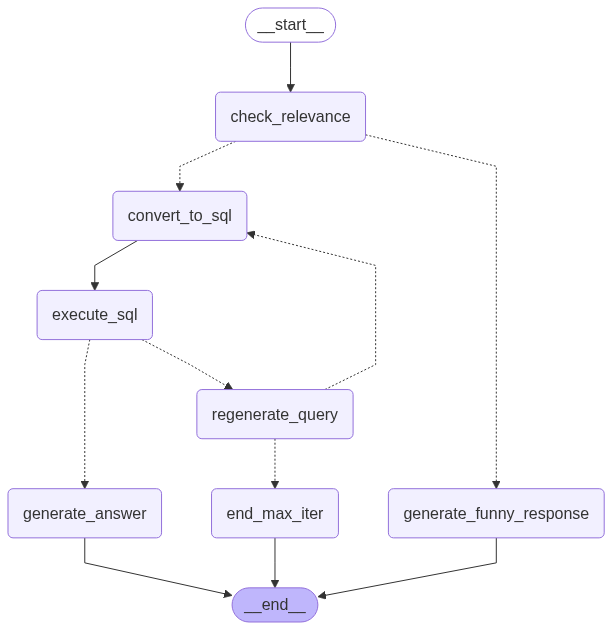

In [71]:
# from IPython.display import display, Markdown

# # Get the Mermaid diagram code directly
# mermaid_code = app.get_graph().draw_mermaid()

# # Display using Markdown
# mermaid_markdown = f"""
# ```mermaid
# {mermaid_code}
# ```
# """

# display(Markdown(mermaid_markdown))
from IPython.display import Image, display

try:
  display(Image(app.get_graph(xray=True).draw_mermaid_png(max_retries=5, retry_delay=2.0)))
except:
  pass

In [ ]:
# Initialize state
state = {
    "question": "",
    "chat_history": [], # adding memory
    "sql_query": "",
    "query_result": "",
    "query_rows": [],
    "attempts": 0,
    "relevance": "",
    "final_answer": "",
    "sql_error": False,
}

while True:
    user_input = input("User: ").strip()
    if user_input.lower() in ["exit", "quit"]:
        print("Conversation ended.")
        break

    state["question"] = user_input
    state["attempts"] = 0  # reset attempts each new question

    result = app.invoke(state)

    answer = result.get("final_answer", "No response available.")

    print(f"Assistant: {answer}\n")

    state["chat_history"].append({"user": user_input, "assistant": answer})

User: What are the top 5 most expensive products?
Checking relevance of the question: What are the top 5 most expensive products?
Relevance determined: relevant
Routing based on relevance...
Converting question to SQL for user: What are the top 5 most expensive products?
Generated SQL query: SELECT "NAME", "listprice" FROM "PRODUCT" ORDER BY "listprice" DESC LIMIT 5
Executing SQL query: SELECT "NAME", "listprice" FROM "PRODUCT" ORDER BY "listprice" DESC LIMIT 5
Routing based on SQL execution result...
Assistant: Based on the results, the top 5 most expensive products are all "Road-150 Red" bicycles with different sizes (52, 44, 62, 56, and 48), and they all have the same list price of $3578.27.

User: Which products are red in color?
Checking relevance of the question: Which products are red in color?
Relevance determined: relevant
Routing based on relevance...
Converting question to SQL for user: Which products are red in color?
Generated SQL query: SELECT "NAME" FROM PRODUCT WHERE "c

Failed to generate SQL: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>{\n  "tool_calls": [\n    {\n      "id": "pending",\n      "type": "function",\n      "function": {\n        "name": "ConvertToSQL"\n      },\n      "parameters": {\n        "sql_query": "SELECT PC.\\"name\\" AS category_name, PSC.\\"name\\" AS subcategory_name\n                        FROM PRODUCTCATEGORY PC\n                        JOIN PRODUCTSUBCATEGORY PSC ON PC.\\"productcategoryid\\" = PSC.\\"productcategoryid\\""\n      }\n    }\n  ]\n}\n</tool-use>'}}
Generated SQL query: 
Executing SQL query: 
Routing based on SQL execution result...
Assistant: Unfortunately, it appears that there are no subcategories under each product category. The result set is empty, indicating that no data was found that matches the specified criteria.



## Evaluation

In [72]:
gold_data_1 = [
    {
        "question": "What are the names of all product categories?",
        "query": 'SELECT "name" FROM ADVENTUREWORKS.ADVENTUREWORKS.PRODUCTCATEGORY;'
    },
    {
        "question": "List all subcategories under each product category.",
        "query": 'SELECT pc."name" AS category_name, psc."name" AS subcategory_name FROM ADVENTUREWORKS.ADVENTUREWORKS.PRODUCTCATEGORY pc JOIN ADVENTUREWORKS.ADVENTUREWORKS.PRODUCTSUBCATEGORY psc ON pc."productcategoryid" = psc."productcategoryid";'
    },
    {
        "question": "Show the average list price of products by color.",
        "query": 'SELECT "color", AVG("listprice") AS avg_price FROM ADVENTUREWORKS.ADVENTUREWORKS.PRODUCT GROUP BY "color";'
    },
    {
        "question": "How many product reviews are there for each product?",
        "query": 'SELECT "productid", COUNT(*) AS review_count FROM ADVENTUREWORKS.ADVENTUREWORKS.PRODUCTREVIEW GROUP BY "productid";'
    },
    {
        "question": "Find the names of all currencies used in different country regions.",
        "query": 'SELECT DISTINCT "currencycode" FROM ADVENTUREWORKS.ADVENTUREWORKS.COUNTRYREGIONCURRENCY;'
    },
    {
        "question": "What is the total sales for each salesperson?",
        "query": 'SELECT "businessentityid", "salesytd" FROM ADVENTUREWORKS.ADVENTUREWORKS.SALESPERSON;'
    },
]

gold_data_2 =  [
    {
        "question": "List sales orders with a total due greater than $10000.",
        "query": 'SELECT "salesorderid", "totaldue" FROM ADVENTUREWORKS.ADVENTUREWORKS.SALESORDERHEADER WHERE "totaldue" > 10000;'
    },
    {
        "question": "What are the top 5 most expensive products?",
        "query": 'SELECT "NAME", "listprice" FROM ADVENTUREWORKS.ADVENTUREWORKS.PRODUCT ORDER BY "listprice" DESC LIMIT 5;'
    },
    {
        "question": "Find all products with a safety stock level below 500.",
        "query": 'SELECT "NAME" FROM ADVENTUREWORKS.ADVENTUREWORKS.PRODUCT WHERE "safetystocklevel" < 500;'
    },
    {
        "question": "Which salesperson has the highest sales year-to-date?",
        "query": 'SELECT "businessentityid", "salesytd" FROM ADVENTUREWORKS.ADVENTUREWORKS.SALESPERSON ORDER BY "salesytd" DESC LIMIT 1;'
    },
    {
        "question": "List all reviews with a rating of 5.",
        "query": 'SELECT "reviewername", "comments" FROM ADVENTUREWORKS.ADVENTUREWORKS.PRODUCTREVIEW WHERE "rating" = 5;'
    },
    {
        "question": "Get all sales orders with their order date and total due.",
        "query": 'SELECT "salesorderid", "orderdate", "totaldue" FROM ADVENTUREWORKS.ADVENTUREWORKS.SALESORDERHEADER;'
    },
    {
        "question": "Get the names of all products manufactured in 1 day.",
        "query": 'SELECT "NAME" FROM ADVENTUREWORKS.ADVENTUREWORKS.PRODUCT WHERE "daystomanufacture" = 1;'
    },
]


In [73]:
print(gold_data_1[0]['question']), print(gold_data_1[0]['query'])

What are the names of all product categories?
SELECT "name" FROM ADVENTUREWORKS.ADVENTUREWORKS.PRODUCTCATEGORY;


(None, None)

In [74]:
for i in range(5):
  print(gold_data_2[i]['question'])

List sales orders with a total due greater than $10000.
What are the top 5 most expensive products?
Find all products with a safety stock level below 500.
Which salesperson has the highest sales year-to-date?
List all reviews with a rating of 5.


In [75]:
len(gold_data_1), len(gold_data_2)

(6, 7)

In [76]:
predictions = []

for i in range(len(gold_data_2)):
  state = {
      "question": gold_data_2[i]["question"],
      "attempts": 0,
  }

  result_state = app.invoke(state)
  predicted_sql = result_state.get("sql_query", "Answer not found")
  print(result_state.get('final_answer', 'No answer'), '\n----\n')

  predictions.append({
      "question": gold_data_2[i]["question"],
      "gold_sql": gold_data_2[i]["query"],
      "predicted_sql": predicted_sql
  })


Checking relevance of the question: List sales orders with a total due greater than $10000.
Relevance determined: relevant
Routing based on relevance...
Converting question to SQL for user: List sales orders with a total due greater than $10000.
Generated SQL query: SELECT salesorderid, totaldue FROM SALESORDERHEADER WHERE totaldue > 10000;
Executing SQL query: SELECT salesorderid, totaldue FROM SALESORDERHEADER WHERE totaldue > 10000;
Error during SQL execution: 000904 (42000): SQL compilation error: error line 1 at position 7
invalid identifier 'SALESORDERID'
Routing based on SQL execution result...
Regenerating the SQL query by rewriting the question.
Rewritten question: List all sales orders from the 'SALESORDERHEADER' table where the 'TOTALDUE' column is greater than $10000.
Attempt #1
Converting question to SQL for user: List all sales orders from the 'SALESORDERHEADER' table where the 'TOTALDUE' column is greater than $10000.
Generated SQL query: SELECT salesorderid, totaldue FR

In [77]:
predictions

[{'question': 'List sales orders with a total due greater than $10000.',
  'gold_sql': 'SELECT "salesorderid", "totaldue" FROM ADVENTUREWORKS.ADVENTUREWORKS.SALESORDERHEADER WHERE "totaldue" > 10000;',
  'predicted_sql': 'SELECT salesorderid, totaldue FROM SALESORDERHEADER WHERE "totaldue" > 10000;'},
 {'question': 'What are the top 5 most expensive products?',
  'gold_sql': 'SELECT "NAME", "listprice" FROM ADVENTUREWORKS.ADVENTUREWORKS.PRODUCT ORDER BY "listprice" DESC LIMIT 5;',
  'predicted_sql': 'SELECT "NAME", "listprice" FROM ADVENTUREWORKS.ADVENTUREWORKS.PRODUCT ORDER BY "listprice" DESC LIMIT 5;'},
 {'question': 'Find all products with a safety stock level below 500.',
  'gold_sql': 'SELECT "NAME" FROM ADVENTUREWORKS.ADVENTUREWORKS.PRODUCT WHERE "safetystocklevel" < 500;',
  'predicted_sql': 'SELECT "productid", "NAME", "safetystocklevel" FROM PRODUCT WHERE "safetystocklevel" < 500;'},
 {'question': 'Which salesperson has the highest sales year-to-date?',
  'gold_sql': 'SELECT 

In [78]:
def run_query(conn, query):
  try:
    with conn.cursor() as cur:
      cur.execute(query)
      return cur.fetchall()
  except Exception as e:
    print(f"Query failed: {e}")
    return None

In [79]:
# run_query(conn, 'SELECT "color" AS color, AVG("listprice") AS average_list_price FROM PRODUCT GROUP BY "color"')

In [80]:
exact_match_count = 0
execution_match_count = 0

for pred in predictions:
  # Exact Match
  if pred["gold_sql"].strip().lower() == pred["predicted_sql"].strip().lower():
    exact_match_count += 1

  # Execution Match
  gold_result = run_query(conn, pred["gold_sql"])
  pred_result = run_query(conn, pred["predicted_sql"])
  if gold_result == pred_result:
    execution_match_count += 1

total = len(predictions)
print(f"Exact Match Accuracy: {exact_match_count}/{total} = {exact_match_count/total:.2f}")
print(f"Execution Accuracy: {execution_match_count}/{total} = {execution_match_count/total:.2f}")

Query failed: 000904 (42000): SQL compilation error: error line 1 at position 7
invalid identifier 'SALESORDERID'
Query failed: 000904 (42000): SQL compilation error: error line 1 at position 7
invalid identifier 'T1.BUSINESSENTITYID'
Query failed: 000904 (42000): SQL compilation error: error line 1 at position 7
invalid identifier 'SALESORDERID'
Exact Match Accuracy: 1/7 = 0.14
Execution Accuracy: 2/7 = 0.29


In [91]:
# Results from first 6 examples gold_data_1
# Exact Match Accuracy: 0/7 = 0
# Execution Accuracy: 4/6 = 0.67

total = len(gold_data_1) + len(gold_data_2)

print(f'Exact Match: 1/{total} = {1/total:.4f}\nExecution Match: 6/{total} = {6/total:.4f}')

Exact Match: 1/13 = 0.0769
Execution Match: 6/13 = 0.4615


In [81]:
import sqlglot
from sqlglot.expressions import Select


def extract_sql_components(sql: str) -> dict:
    try:
        parsed = sqlglot.parse_one(sql)
    except Exception as e:
        return {
            "columns": set(),
            "tables": set(),
            "keywords": set(),
            "error": str(e),
        }

    columns: set[str] = set()
    tables: set[str] = set()
    keywords: set[str] = set()

    for column in parsed.find_all(sqlglot.expressions.Column):
        if column.name:
            columns.add(column.name.lower())

    for table in parsed.find_all(sqlglot.expressions.Table):
        if table.name:
            tables.add(table.name.lower())

    if isinstance(parsed, Select):
        if parsed.args.get("where"):
            keywords.add("where")
        if parsed.args.get("group"):
            keywords.add("group")
        if parsed.args.get("order"):
            keywords.add("order")
        if parsed.args.get("having"):
            keywords.add("having")
        if parsed.args.get("limit"):
            keywords.add("limit")
        if parsed.args.get("joins"):
            keywords.add("join")

    return {
        "columns": columns,
        "tables": tables,
        "keywords": keywords,
    }


def jaccard_similarity(set1: set[str], set2: set[str]) -> float:
    if not set1 and not set2:
        return 1.0
    return len(set1 & set2) / len(set1 | set2)


def compute_sql_partial_match(predicted_sql: str, gold_sql: str) -> dict:
    pred = extract_sql_components(predicted_sql)
    gold = extract_sql_components(gold_sql)

    col_score = jaccard_similarity(pred["columns"], gold["columns"])
    table_score = jaccard_similarity(pred["tables"], gold["tables"])
    keyword_score = jaccard_similarity(pred["keywords"], gold["keywords"])

    total_score = 0.5 * col_score + 0.3 * table_score + 0.2 * keyword_score

    return {
        "column_score": col_score,
        "table_score": table_score,
        "keyword_score": keyword_score,
        "total_score": total_score
    }

In [82]:
import re

def normalize_sql(sql: str) -> list[str]:
  sql = sql.lower().strip()
  # Remove symbols for cleaner splitting
  sql = re.sub(r'[(),;<>=]', '', sql)
  return sql.split()


def compute_f1(prediction: str|dict[str, float], truth: str|dict[str, float]) -> int | float:
  if isinstance(prediction, str) and isinstance(truth, str):
    pred_tokens = normalize_sql(prediction)
    truth_tokens = normalize_sql(truth)

  pred_tokens = prediction
  truth_tokens = truth

  # if either the prediction or the truth has no-answer then f1 = 1 if they agree, 0 otherwise
  if len(pred_tokens) == 0 or len(truth_tokens) == 0:
    return int(pred_tokens == truth_tokens)

  common_tokens = set(pred_tokens) & set(truth_tokens)

  # if there are no common tokens then f1 = 0
  if len(common_tokens) == 0:
    return 0

  prec = len(common_tokens) / len(pred_tokens)
  rec = len(common_tokens) / len(truth_tokens)

  return 2 * (prec * rec) / (prec + rec)

In [83]:
def f1_score(pred_sql, gold_sql):
  pred = extract_sql_components(pred_sql)
  gold = extract_sql_components(gold_sql)

  column_f1 = compute_f1(pred["columns"], gold["columns"])
  table_f1 = compute_f1(pred["tables"], gold["tables"])
  keyword_f1 = compute_f1(pred["keywords"], gold["keywords"])

  # weighted_f1 = 0.5 * column_f1 + 0.3 * table_f1 + 0.2 * keyword_f1 # weighted f1 score
  macro_f1 = (column_f1 + table_f1 + keyword_f1) / 3 # macro f1 score
  return {
      "column_f1": column_f1,
      "table_f1": table_f1,
      "keyword_f1": keyword_f1,
      "macro_f1": macro_f1,
      # "weighted_f1": weighted_f1
  }

In [84]:
f1_scores = []
partial_matches = []

for pred in predictions:
  partial_matches.append(compute_sql_partial_match(pred["predicted_sql"], pred["gold_sql"]))
  f1_scores.append(f1_score(pred["predicted_sql"], pred["gold_sql"]))

avg_f1 = {
  "column_f1": sum([f1["column_f1"] for f1 in f1_scores]) / len(f1_scores),
  "table_f1": sum([f1["table_f1"] for f1 in f1_scores]) / len(f1_scores),
  "keyword_f1": sum([f1["keyword_f1"] for f1 in f1_scores]) / len(f1_scores),
  "macro_f1": sum([f1["macro_f1"] for f1 in f1_scores]) / len(f1_scores),
  # "weighted_f1": sum([f1["weighted_f1"] for f1 in f1_scores]) / len(f1_scores)
}

avg_partial_match = {"total_score": sum([pm["total_score"] for pm in partial_matches]) / len(partial_matches)}

In [85]:
print(f'f1-score: {avg_f1}\nPartial Match: {avg_partial_match}')

f1-score: {'column_f1': 0.9, 'table_f1': 1.0, 'keyword_f1': 1.0, 'macro_f1': 0.9666666666666667}
Partial Match: {'total_score': 0.9285714285714286}


In [86]:
# Results from first 6 examples gold_data_1
# f1-score: {'column_f1': 0.7444444444444445, 'table_f1': 0.7777777777777777, 'keyword_f1': 0.9444444444444443, 'macro_f1': 0.8222222222222221}
# Partial Match: {'total_score': 0.7555555555555555}

In [87]:
n1 = len(gold_data_1)
n2 = len(gold_data_2)
total = n1 + n2

# gold_data_1 f1-scores
f1_part1 = {
    'column_f1': 0.7444444444444445,
    'table_f1': 0.7777777777777777,
    'keyword_f1': 0.9444444444444443,
    'macro_f1': 0.8222222222222221
}

# gold_data_2 f1-scores
f1_part2 = {'column_f1': 0.9,
            'table_f1': 1.0,
            'keyword_f1': 1.0,
            'macro_f1': 0.9666666666666667}

# partial match
partial_match_1 = 0.7555555555555555
partial_match_2 = 0.9285714285714286

# combined f1-scores using weighted average
combined_f1 = {
    key: (f1_part1[key] * n1 + f1_part2[key] * n2) / total
    for key in f1_part1
}

# combined partial match scores
combined_partial_match = (partial_match_1 * n1 + partial_match_2 * n2) / total


print("Combined F1 Scores:")
for k, v in combined_f1.items():
    print(f"{k}: {v:.4f}")

print("\nCombined Partial Match Score:")
print(f"total_score: {combined_partial_match:.4f}")


Combined F1 Scores:
column_f1: 0.8282
table_f1: 0.8974
keyword_f1: 0.9744
macro_f1: 0.9000

Combined Partial Match Score:
total_score: 0.8487


In [ ]:
# AdventureWorks Schema

# create or replace TABLE ADVENTUREWORKS.ADVENTUREWORKS.COUNTRYREGIONCURRENCY (
# 	"countryregioncode" VARCHAR(16777216),
# 	"currencycode" VARCHAR(16777216),
# 	"modifieddate" VARCHAR(16777216)
# );

# create or replace TABLE ADVENTUREWORKS.ADVENTUREWORKS.CURRENCYRATE (
# 	"currencyrateid" NUMBER(38,0),
# 	"currencyratedate" VARCHAR(16777216),
# 	"fromcurrencycode" VARCHAR(16777216),
# 	"tocurrencycode" VARCHAR(16777216),
# 	"averagerate" FLOAT,
# 	"endofdayrate" FLOAT,
# 	"modifieddate" VARCHAR(16777216)
# );

# create or replace TABLE ADVENTUREWORKS.ADVENTUREWORKS.PRODUCT (
# 	"productid" NUMBER(38,0),
# 	NAME VARCHAR(16777216),
# 	"productnumber" VARCHAR(16777216),
# 	"makeflag" VARCHAR(16777216),
# 	"finishedgoodsflag" VARCHAR(16777216),
# 	"color" VARCHAR(16777216),
# 	"safetystocklevel" NUMBER(38,0),
# 	"reorderpoint" NUMBER(38,0),
# 	"standardcost" FLOAT,
# 	"listprice" FLOAT,
# 	"size" VARCHAR(16777216),
# 	"sizeunitmeasurecode" VARCHAR(16777216),
# 	"weightunitmeasurecode" VARCHAR(16777216),
# 	"weight" VARCHAR(16777216),
# 	"daystomanufacture" NUMBER(38,0),
# 	"productline" VARCHAR(16777216),
# 	"class" VARCHAR(16777216),
# 	"style" VARCHAR(16777216),
# 	"productsubcategoryid" VARCHAR(16777216),
# 	"productmodelid" VARCHAR(16777216),
# 	"sellstartdate" VARCHAR(16777216),
# 	"sellenddate" VARCHAR(16777216),
# 	"discontinueddate" VARCHAR(16777216),
# 	"rowguid" VARCHAR(16777216),
# 	"modifieddate" VARCHAR(16777216)
# );

# create or replace TABLE ADVENTUREWORKS.ADVENTUREWORKS.PRODUCTCATEGORY (
# 	"productcategoryid" NUMBER(38,0),
# 	"name" VARCHAR(16777216),
# 	"rowguid" VARCHAR(16777216),
# 	"modifieddate" VARCHAR(16777216)
# );

# create or replace TABLE ADVENTUREWORKS.ADVENTUREWORKS.PRODUCTDESCRIPTION (
# 	"productdescriptionid" NUMBER(38,0),
# 	"description" VARCHAR(16777216),
# 	"rowguid" VARCHAR(16777216),
# 	"modifieddate" VARCHAR(16777216)
# );

# create or replace TABLE ADVENTUREWORKS.ADVENTUREWORKS.PRODUCTMODELPRODUCTDESCRIPTIONCULTURE (
# 	"productmodelid" NUMBER(38,0),
# 	"productdescriptionid" NUMBER(38,0),
# 	"cultureid" VARCHAR(16777216),
# 	"modifieddate" VARCHAR(16777216)
# );

# create or replace TABLE ADVENTUREWORKS.ADVENTUREWORKS.PRODUCTREVIEW (
# 	"productreviewid" NUMBER(38,0),
# 	"productid" NUMBER(38,0),
# 	"reviewername" VARCHAR(16777216),
# 	"reviewdate" VARCHAR(16777216),
# 	"emailaddress" VARCHAR(16777216),
# 	"rating" NUMBER(38,0),
# 	"comments" VARCHAR(16777216),
# 	"modifeddate" VARCHAR(16777216),
# 	"modifieddate" VARCHAR(16777216)
# );

# create or replace TABLE ADVENTUREWORKS.ADVENTUREWORKS.PRODUCTSUBCATEGORY (
# 	"productsubcategoryid" NUMBER(38,0),
# 	"productcategoryid" NUMBER(38,0),
# 	"name" VARCHAR(16777216),
# 	"rowguid" VARCHAR(16777216),
# 	"modifieddate" VARCHAR(16777216)
# );

# create or replace TABLE ADVENTUREWORKS.ADVENTUREWORKS.SALESORDERDETAIL (
# 	"salesorderid" NUMBER(38,0),
# 	"salesorderdetailid" NUMBER(38,0),
# 	"carriertrackingnumber" VARCHAR(16777216),
# 	"orderqty" NUMBER(38,0),
# 	"productid" NUMBER(38,0),
# 	"specialofferid" NUMBER(38,0),
# 	"unitprice" FLOAT,
# 	"unitpricediscount" FLOAT,
# 	"rowguid" VARCHAR(16777216),
# 	"modifieddate" VARCHAR(16777216)
# );

# create or replace TABLE ADVENTUREWORKS.ADVENTUREWORKS.SALESORDERHEADER (
# 	"salesorderid" NUMBER(38,0),
# 	"revisionnumber" NUMBER(38,0),
# 	"orderdate" VARCHAR(16777216),
# 	"duedate" VARCHAR(16777216),
# 	"shipdate" VARCHAR(16777216),
# 	STATUS VARCHAR(16777216),
# 	"onlineorderflag" VARCHAR(16777216),
# 	"purchaseordernumber" VARCHAR(16777216),
# 	"accountnumber" VARCHAR(16777216),
# 	"customerid" NUMBER(38,0),
# 	"salespersonid" VARCHAR(16777216),
# 	"territoryid" NUMBER(38,0),
# 	"billtoaddressid" NUMBER(38,0),
# 	"shiptoaddressid" NUMBER(38,0),
# 	"shipmethodid" NUMBER(38,0),
# 	"creditcardid" VARCHAR(16777216),
# 	"creditcardapprovalcode" VARCHAR(16777216),
# 	"currencyrateid" VARCHAR(16777216),
# 	"subtotal" FLOAT,
# 	"taxamt" FLOAT,
# 	"freight" FLOAT,
# 	"totaldue" FLOAT,
# 	"comment" VARCHAR(16777216),
# 	"rowguid" VARCHAR(16777216),
# 	"modifieddate" VARCHAR(16777216)
# );

# create or replace TABLE ADVENTUREWORKS.ADVENTUREWORKS.SALESPERSON (
# 	"businessentityid" NUMBER(38,0),
# 	"territoryid" VARCHAR(16777216),
# 	"salesquota" VARCHAR(16777216),
# 	"bonus" NUMBER(38,0),
# 	"commissionpct" FLOAT,
# 	"salesytd" FLOAT,
# 	"saleslastyear" FLOAT,
# 	"rowguid" VARCHAR(16777216),
# 	"modifieddate" VARCHAR(16777216)
# );

# create or replace TABLE ADVENTUREWORKS.ADVENTUREWORKS.SALESPERSONQUOTAHISTORY (
# 	"BusinessEntityID" NUMBER(38,0),
# 	"QuotaDate" VARCHAR(16777216),
# 	"SalesQuota" FLOAT,
# 	"rowguid" VARCHAR(16777216),
# 	"ModifiedDate" VARCHAR(16777216)
# );

# create or replace TABLE ADVENTUREWORKS.ADVENTUREWORKS.SALESTERRITORY (
# 	"territoryid" NUMBER(38,0),
# 	"name" VARCHAR(16777216),
# 	"countryregioncode" VARCHAR(16777216),
# 	"group" VARCHAR(16777216),
# 	"salesytd" FLOAT,
# 	"saleslastyear" FLOAT,
# 	"costytd" FLOAT,
# 	"costlastyear" FLOAT,
# 	"rowguid" VARCHAR(16777216),
# 	"modifieddate" VARCHAR(16777216)
# );